# Introduction
Le but de cet exercice est de vous familiariser avec les RNNs.
Nous allons utiliser les RNNs dans deux configurations differentes.

*   Comme feature extractor de donnée sequentielles (similaire à l'usage d'un CNN pour des images).
*   Comme "decodeur" pour generer des données sequentielles.

La grande particularitée des RNNs est de pouvoir être uttilisé pour des données sequentielles avec une longueur arbitraire.

## Inductif bias d'un RNN

Le RNN à comme inductif bias qu'il existe un état caché h qui est Markov ie l'état du prochain état caché est dependant que de l'état caché actuel.

## RNNs comme extracteur de feature

![Image Feature Extractor](https://stanford.edu/~shervine/teaching/cs-230/illustrations/rnn-many-to-one.png)

Dans cette usage la structure mathematique est la suivante:

```
h=LSTM(x)
y=MLP(h)
```
Où h est une extraction de feature representant la sequence entière (similaire à un CNN avant le fully connected).

Et le dernier MLP utilise les features extraient pour résoudre le problème.

## RNNs comme generateur de sequence

![Image Rnn sequence generator](https://stanford.edu/~shervine/teaching/cs-230/illustrations/rnn-one-to-many.png)


Dans cette usage la structure mathematique est la suivante:



```
h0=MLP(x)
y0=0
ht+1=LSTM(yt,ht)
ypt+1=MLP(ht+1)
```

Où h0 est l'extraction de feature depuis les attributs d'entrée.
Le RNN est ensuite utilisé pour generer une representation à chaque temps t (ht) depuis la representation precedent (ht-1) et la prediction au temps precedent (yt-1).
Depuis la representation ht on obtient la prediction au temps t avec un MLP.

## Dataset

Pour cet exercice, vous avez accès au dataset artificiel contenant une pair (x,y) suivante:

*   x decrit les characteristiques de y comme la pente, frequence ...
*   y est une sequence de longueur variable.

Pour se dataset la longueur de la sequence n'a pas besoin d'être predite.

## Ce qu'il faut faire:

1. Completer le code pour le cas "feature extractor".
2. Completer le code pour le cas "sequence generator".
3. Dessiner un graph computationel de chaque composante ainsi que la taille des differentes matrices. Décrivez aussi pourquoi le model est capable de fonctioner avec des longueurs de sequence differentes.

Voir computational_graph.jpeg.

Dans le cas du sequence generator, $B = 1, H = 1, D = 5$.
Dans le schéma je n'ai pas tout décrit mais dans le cas du sequence generator, tous les éléments $y$ contribuent à la loss, alors que dans le cas du feature extractor, seul le dernier compte.
Aussi, dans le cas du feature extractor, on aurait aussi un MLP à la fin.

Le modèle est capable d'avoir une taille dynamique parce qu'ils marche de forme récursive. C'est-à-dire, un LSTM contient plusieurs matrices de poids $w$ mais elles sont toutes partagés par touts les timesteps. Une couche LSTM peut se rappeller (dans le sens appel de fonction par exemple) jusqu'à ce qu'on arrive à la fin d'une séquence. La puissance de cet LSTM c'est qu'il peut se souvenir ce qui est déjà passé ou pas. Ceci est très important lorsqu'on utilise des graphs computationnels dynamiques. En effet, à chaque éxécution, la taille de ce graph peut changer. Par contre, cela aura pour désavantages de devoir garder en mémoire tous les timesteps pour pouvoir calculer la backpropagation correctement. De plus, lors de la backprop, il faut calculer l'erreur indépendamment, et l'update des poids se fait en calculant la somme de toutes les gradients à travers le temps.

4. Repondez à la liste de questions suivante:

  1. Pour le cas du "feature extractor" que veux dire si l'état caché hn est le même pour deux instances differentes et quel consequence sur la prediction?

  Cela voudrait dire que la prédiction sera similaire. En effet, pour que cela arrive, c'est que les opérations faites avant était également similaires. Il ne faut pas oublier qu'il y a encore le $c_n$, nous pouvons donc avoir quand-même des prédictions différentes car le LSTM peut choisir d'oublier certaines informations.

  2. Pour le cas du "sequence generator" que veux dire si l'état caché ht est le même pour deux instances differentes et quel consequence sur les predictions futur?

  Je dirais que les prédictions seraient également similaires. Mais encore une fois, puisque le $c_n$ peuvent être différents, dans le long terme, les points générateurs se rapprocheront moins de l'autre instace.

  3. Pour le cas du "sequence generator" pourquoi y a t-il deux processus de prediction une utilisé en train et une utilisé à l'évaluation? Quel est la difference? Quels sont les avantages de chaque methode?

  La première méthode et utilisée lors de la phase d'entrainement et nous connaissons les vraies valeurs que le LSTM doit avoir en input. 
  Nous pouvons les utiliser pour que le LSTM apprenne plus vite. Cependant, dans la phase de test (2ème méthode), nous devons utiliser les prédictions d'une étape précédente en tant que l'input de la prochaine étape pour que la génération se fasse correctement.

  La première méthode possède la qualité de permettre au réseau d'apprendre plus vite. Cependant, lorsque nous passons d'une méthode à une autre, rien ne nous assure que le réseau aura un comportement similaire à celui vu dans la phase d'entrainement. La deuxième méthode possède en plus le défaut de "dégénérer" lorsqu'il faut une mauvaise prédiction. C'est-à-dire, dès que le réseau fait une erreur, il ne peut faire que des erreurs par la suite.












# Code Commun

Import de modul util.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.nn.utils.rnn as rnnUtils
import random

Fonction qui genère des times-series.

In [0]:
# Genère une courbe sinuosidal avec la frequence, phase et amplitude donné d'une longueur length.
def generateWave(frequency,phase,amplitude,length):
  return np.sin(np.arange(0,length)*frequency*2*math.pi+phase)*amplitude

#Genère une fonction linéaire avec une slope et origin donné.
def generateLinear(slope,origin,length):
  return slope*np.arange(0,length)+origin

#Genère l'addition des deux fonctions precedentes.
def generate(frequency,phase,amplitude,slope,origin,length):
  return generateWave(frequency,phase,amplitude,length)+generateLinear(slope,origin,length)

In [0]:
#Fonction generant les données.
def GenerateData(size):
  #Trois variable utilisé comme donnée.
  #Time series.
  dataWave=[]
  #Time series shifté avec 0 comme première valeur et allant jusqu'a T-1.
  dataWaveShifted=[]
  #Attribut de la time series.
  dataAttribute=[]
  for i in range(0,size):
    #Sample attribut.
    frequency=random.uniform(0.01,0.1)
    phase=random.uniform(0,2*math.pi)
    amplitude=random.uniform(0.1,10)
    slope=random.uniform(-1,1)
    origin=random.uniform(-1,1)
    length=random.randint(50,100)
    #Genère la courbe à partir des attributs.
    wave=torch.unsqueeze(torch.Tensor(generate(frequency,phase,amplitude,slope,origin,length)),1)
    #Ajoute la courbe à la liste des courbes
    dataWave.append(wave)
    #Ajoute la courbe shifted.
    dataWaveShifted.append(torch.cat((torch.zeros(1,1),wave[0:-1])))
    #Ajoute les attributs.
    dataAttribute.append(np.array([amplitude,frequency,phase,slope,origin]))

  dataAttribute=torch.Tensor(dataAttribute).cuda()
  #Crée un objet pack sequence representant une sequence ( https://pytorch.org/docs/stable/_modules/torch/nn/utils/rnn.html )
  #Le False indique que les longueurs ne sont pas ordonné.
  dataWave=rnnUtils.pack_sequence(dataWave,False).cuda()
  #Idem pour les courbes shifted.
  dataWaveShifted=rnnUtils.pack_sequence(dataWaveShifted,False).cuda()
  return (dataAttribute,dataWave,dataWaveShifted)

#Genère donnée de train / test
TrainAttribute,TrainWave,TrainWaveShifted=GenerateData(5000)
TestAttribute,TestWave,TestWaveShifted=GenerateData(1000)


# Code feature extractor

In [0]:
#Class implementant le model à completer.
class MyLayer(torch.nn.Module):
    def __init__(self,inputSize,lstmSize,mlpSize,outputSize):
        super(MyLayer, self).__init__()
        self.output_size = outputSize
        #definir self.lstm avec un objet lstm avec les dimensions correct (cf https://pytorch.org/docs/stable/nn.html#lstm ) .
        self.lstm = nn.LSTM(inputSize, lstmSize, batch_first=True)
        #Regardez bien si vous avez besoin de l'option batch_first=True .

        #definir self.decoder à un mlp avec Relu avec comme couche caché mlpSize.

        self.hidden = nn.Linear(lstmSize, mlpSize)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(mlpSize, outputSize)
        
    def forward(self, input):
      #Utilisez self.lstm et self.decoder pour calculer la sortie.
      output, _ = self.lstm(input) 
      #Atention la sortie de self.lstm est de la forme outputLSTM,(hn,cn) reflechisez à quel componente
      #Vous avez besoin pour le decoder.

      output = self.hidden(output.data[-1].squeeze(0))

      output = self.relu(output)

      output = self.decoder(output)
      #Atention la sortie de self.lstm est de la forme outputLSTM,(hn,cn) reflechisez à quel componente
      #Vous avez besoin pour le decoder.
      #Il est possible que vous aurez besoin d'un squeeze(0).
      return output

# Add question on what the output of self.lstm is.
Dans un LSTM nous avons l'output du LSTM qui est le $y$, et nous avons un tuple qui nous est également retourné qui correspond au hidden state et au cell state, respectivement.

#explain batch dimension.

La taille du batch est la première dimension de la matrice. C'est pour cela que nous devons utiliser bitch_first = True

#explain difference between first and other variable
Je ne suis pas sûr de comprendre la question.
Est-ce que c'est les timesteps $t$ et les caractéristiques de chaque instance ?



In [0]:
# Definir le model et passer sur GPU.
model=MyLayer(1,128,128,5).cuda()

In [0]:
# Definir criterion comme la loss que vous voulez utiliser (MSE)
criterion = nn.MSELoss()
# Definir optimizer comme (Adam avec learningdataWave rate de 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [161]:
#Loop de Training
for i in range (0,5000) :
#Mettre les gradients des paramêtres à zero.
  optimizer.zero_grad()
  #Definir PredWave comme le forward du model.
  PredWave = model.forward(TrainWave)
  #Definir l'erreur de la prediction en utilisant le criterion.
  error = criterion(TrainAttribute, PredWave)
  #Faire le backward.
  error.backward()
  #Faire le forward du test.
  with torch.no_grad():
    test_wave = model.forward(TestWave)
    errorTest = criterion(test_wave, TestAttribute)

  #Definir errorTest comme l'erreur sur le test.
  print(i,' ',error,' ',errorTest)
  #Mettre à jour les poids.
  optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5000, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1000, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0   tensor(9.7695, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(9.5047, device='cuda:0')
1   tensor(9.3920, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(9.5787, device='cuda:0')
2   tensor(9.0694, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(9.6428, device='cuda:0')
3   tensor(8.7544, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(9.7087, device='cuda:0')
4   tensor(8.4879, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(9.7864, device='cuda:0')
5   tensor(8.2168, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(9.8536, device='cuda:0')
6   tensor(7.9351, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(9.9170, device='cuda:0')
7   tensor(7.6337, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(9.9759, device='cuda:0')
8   tensor(7.3103, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(10.0197, device='cuda:0')
9   tensor(6.9752, device='cuda:0', grad_fn=<MeanBackward0>)   tensor(10.0424, device='cuda:0')
10   tensor(6.6119, device='cuda:0', grad_fn=<Me

In [167]:
#Code d'exemple de calcul de prediction.
PredWave=model(TestWave)
error=criterion(PredWave,TestAttribute)
print(error)
print(PredWave[0])
print(TestAttribute[0])

TypeError: ignored

# Sequence Generator

In [0]:
#Model pour la generation de sequence.
class MyLayer(torch.nn.Module):
    def __init__(self,inputSize,lstmSize,mlpSize,outputSize):
        super(MyLayer, self).__init__()

        self.lstmSize = lstmSize
        #definir self.lstm pour la composante LSTM verifier is vous avez besoin de batch_first=True
        self.lstm = nn.LSTM(inputSize, lstmSize, batch_first=True)
        #Definir self.encoderHidden à un MLP avec relu utilisez mlpSize comme taille de neurone intermediaire.
        
        self.encoderHidden = nn.Linear(lstmSize, mlpSize)
        self.relu = nn.ReLU()
        self.encoderOutput = nn.Linear(lstmSize, mlpSize)

        #Definir de facon similaire self.encoderCell.
        self.encoderCell = nn.Linear(lstmSize, mlpSize)
        self.reluCell = nn.ReLU()
        self.encoderCellOutput = nn.Linear(lstmSize, mlpSize)

        #Definir self.outputLayer comme un MLP calculant la prediction.

        self.output = nn.Linear(lstmSize, outputSize)

    #input est les attributs, past est les donnée du passé comme entrée du lstm. 
    def forward(self, input,past):
      h0, c0 = self.init_hidden(1)

      #Definir h0 comme hidden state initial du encoder
      h0 = self.encoderHidden(h0)
      h0 = self.relu(h0)
      h0 = self.encoderOutput(h0)
      
      #Definir c0 comme cell state initial du encoder
      c0 = self.encoderCell(c0)
      c0 = self.reluCell(c0)
      c0 = self.encoderCellOutput(c0)
      #Utiliser self.lstm pour le lstm il est possible que vous aurez besoin de unsqueeze(0).
      
      out, _ = self.lstm(input.unsqueeze(0), (h0, c0))
      
      #Parceque le output layer ne supporte pas les données packed pour longueur differente, nous devons les unpack (cf fonction pad_packed_sequence https://pytorch.org/docs/stable/_modules/torch/nn/utils/rnn.html )
      #Verifier si vous avez besoin de batch_first=True
      output = rnnUtils.pad_packed_sequence(rnnUtils.pack_sequence(out,False), batch_first=True)
      #L'operation de unpack vas padder avec des zeros de façon à tenir avec la taille maximal de la sequence.
      #Definir output comme la sortie après le output Layer
      #utiliser une des sorties de pad_packed_sequence utilisé precedement pour remplacer par des zeros la fin de la sequence (ie un masque)
      #Une facon de faire cela est d'utiliser  pack_padded_sequence suivit de pad_packed_sequence avec les options correct de batch_first et enforce_sorted.
      return self.output(output[0])

    def init_hidden(self, batch_size):
        hidden = torch.autograd.Variable(next(self.parameters()).data.new(1, batch_size, self.lstmSize), requires_grad = True)
        cell =  torch.autograd.Variable(next(self.parameters()).data.new(1, batch_size, self.lstmSize), requires_grad = True)
        return (hidden, cell)

    #Fonction utilisé pour l'évaluation de la prediction. Cette fonction est necessaire que après le train. Completez cette fonction à la fin.
    #input est l'attribut d'entrée length est la longeur de sortie de la sequence.
    def prediction(self,input,length):
      #return TotalLSTMPred
      h0, c0 = self.init_hidden(1)

      #Definir h0 comme hidden state initial du encoder
      h0 = self.encoderHidden(h0)
      h0 = self.relu(h0)
      h0 = self.encoderOutput(h0)
      
      #Definir c0 comme cell state initial du encoder
      c0 = self.encoderCell(c0)
      c0 = self.reluCell(c0)
      c0 = self.encoderCellOutput(c0)

      #definir batchsize comme la time du batch.
      #definir lastLSTMPred comme un vecteur de zero sur gpu.
      lastLSTMPred = torch.zeros(input.size()[1]).cuda() # Je ne comprends pas à quoi ça sert
      for i in range(length):
        #utilisez self.lstm ainsi que h et c ainsi que la prediction precedent pour calculer le prochain state de sortie.
        out, (h0, c0) = self.lstm(input.unsqueeze(0), (h0, c0)) # Je pense que j'aurais dû utiliser
        # lastLSTMPred ici mais je ne comprends pas comment le faire et je commence à essayer tout et n'importe quoi
        #utilisez le state de sortie pour calculer la prochaine prediction.
        next_lstm_pred = self.output(out)[:,-1,:]
        if i==0:
          #Definisez TotalLSTMPred comme la prediction.
          TotalLSTMPred = [next_lstm_pred.item()]
        else :
          #Definisez TotalLSTMPred comme la prediction en append la nouvel prediction qu'on vient de faire.
          TotalLSTMPred.append(next_lstm_pred.item())

          lastLSTMPred = next_lstm_pred
          #print(lastLSTMPred.shape)
          #print("Setting next pred")
      
      return TotalLSTMPred


In [0]:
#Definition du model et passer sur GPU.
model=MyLayer(5,128,128,1).cuda()

In [0]:
# Definir criterion comme la loss que vous voulez utiliser (MSE)
criterion = nn.MSELoss()
# Definir optimizer comme (Adam avec learningdataWave rate de 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [166]:
for i in range (0,5000) :
  #Mettre les gradients des poids du model à zero.
  optimizer.zero_grad()
  #Definir PredWave comme le forward du model.
  predWave = model.forward(TrainAttribute, 0)
  #Definir error comme l'erreur de la prediction. Come la "target" est sous for packed il faut unpack (pad_packed_sequence) verifiez si vous avez besoin de batch_first
  targetWave = rnnUtils.pad_packed_sequence(TrainWave)[0][0]
  error = criterion(predWave, targetWave)
  #Appliquez le backward.
  error.backward()
  #Calculez la prediction du model sur le test
  testPred = model(TestAttribute, 0) # Utiliser Predict mais ne marche pas bien ...
  #Calculez l'erreur sur le test.
  targetWave = rnnUtils.pad_packed_sequence(TestWave)[0][0]
  errorTest = criterion(testPred, targetWave)
  print(i,' ',error,' ',errorTest)
  #Fair l'update des poids.
  optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([5000, 1])) that is different to the input size (torch.Size([1, 5000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1, 1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0   tensor(16.9077, device='cuda:0', grad_fn=<MseLossBackward>)   tensor(16.9062, device='cuda:0', grad_fn=<MseLossBackward>)
1   tensor(16.8420, device='cuda:0', grad_fn=<MseLossBackward>)   tensor(16.8060, device='cuda:0', grad_fn=<MseLossBackward>)
2   tensor(16.7838, device='cuda:0', grad_fn=<MseLossBackward>)   tensor(16.7196, device='cuda:0', grad_fn=<MseLossBackward>)
3   tensor(16.7295, device='cuda:0', grad_fn=<MseLossBackward>)   tensor(16.6442, device='cuda:0', grad_fn=<MseLossBackward>)
4   tensor(16.6763, device='cuda:0', grad_fn=<MseLossBackward>)   tensor(16.5765, device='cuda:0', grad_fn=<MseLossBackward>)
5   tensor(16.6224, device='cuda:0', grad_fn=<MseLossBackward>)   tensor(16.5144, device='cuda:0', grad_fn=<MseLossBackward>)
6   tensor(16.5666, device='cuda:0', grad_fn=<MseLossBackward>)   tensor(16.4559, device='cuda:0', grad_fn=<MseLossBackward>)
7   tensor(16.5087, device='cuda:0', grad_fn=<MseLossBackward>)   tensor(16.4001, device='cuda:0', grad_fn=<MseLossBac

torch.Size([100, 1])


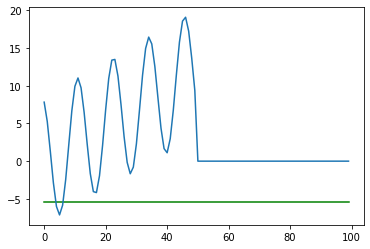

In [168]:
#Exemple de code de prediction.
Prediction=model.prediction(TestAttribute,100)
x=Prediction
xtarget=rnnUtils.pad_packed_sequence(TestWave,batch_first=True)[0].cpu().detach()[0]
print(xtarget.shape)
plt.plot(x, color="green")
plt.plot(xtarget)